# Application Development (Earth Observation)
## Wildfire Burn Severity Classification using ResNet+FPN Enhancement and Interactive OBIA

This notebook implements an end-to-end workflow for creating wildfire burn severity maps from historical fire data. The approach combines deep learning feature enhancement with OBIA to transform pixel-level susceptibility predictions into spatially coherent fire risk zones.

The workflow processes [CLIMAAX](https://github.com/CLIMAAX/FIRE/tree/main) fire data for Catalonia (1991-2022), creates baseline susceptibility maps using fire proximity and environmental factors, applies ResNet+FPN enhancement for multi-scale spatial feature extraction, and implements 5-class burn severity classification. An interactive Gradio interface enables real-time parameter exploration, inspired by eCognition's GUI-based OBIA approach but accessible.

Key contributions:
- Integration of pre-trained CNN features for susceptibility enhancement
- Direct threshold-based classification avoiding complex segmentation
- Interactive parameter exploration interface for operational use
- Comprehensive validation against historical fire locations



# 01. Setup

In [1]:
!git clone https://github.com/CLIMAAX/FIRE.git

Cloning into 'FIRE'...
remote: Enumerating objects: 631, done.
remote: Counting objects: 100% (234/234), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 631 (delta 151), reused 173 (delta 106), pack-reused 397 (from 2)
Receiving objects: 100% (631/631), 72.93 MiB | 36.36 MiB/s, done.
Resolving deltas: 100% (374/374), done.


Install required packages

In [2]:
!pip install rasterio geopandas rioxarray scikit-image gradio
!pip install pooch  # for climaax data

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 4.9 MB/s eta 0:00:00


Import required libraries

In [ ]:
# import shared_funcs
import os
import pathlib
import pooch
import numpy as np
import geopandas as gpd
import rasterio
from rasterio import features
import rasterio.plot
from rasterio.mask import mask
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from skimage.segmentation import slic, mark_boundaries
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects
import gradio as gr
from tqdm import tqdm
from scipy.ndimage import distance_transform_edt, gaussian_filter
from skimage.filters import gabor, gaussian
from skimage.feature import local_binary_pattern

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights, ResNet101_Weights

**Download data**

Now we download CLIMAAX's Catalonia sample dataset. The dataset includes fire records (1986-2022), climate data, exposure data, etc.

In [4]:
os.chdir('/content/FIRE/01_wildfire_ML')

# set up catalonia
areaname = "Catalonia"
data_path_area = pathlib.Path(f"./data_{areaname}")

# download sample data
sample_pooch = pooch.create(
    path=".",
    base_url="https://object-store.os-api.cci1.ecmwf.int/climaax/wildfire_sample_cat/"
)

sample_pooch.load_registry("files_registry_cat.txt")
print(f"Found {len(sample_pooch.registry)} files in registry")

# download all files just in case
for path in sample_pooch.registry:
    sample_pooch.fetch(path)
print("Download complete!")

Found 121 files in registry


Download complete!


# 02. Data preparation + base susceptibility mapping

## Environment setup + data download

In [5]:
areaname = "Catalonia"
data_path_area = pathlib.Path(f"./data_{areaname}")

# key file paths
dem_path = data_path_area / "dem"
clc_path = data_path_area / "land_cover"
fires_path = data_path_area / "fires"
suscep_path = data_path_area / "susceptibility"
bounds_path = data_path_area / "boundaries"
clim_path = data_path_area / "climate"

# directories
for path in [dem_path, clc_path, suscep_path]:
    path.mkdir(parents=True, exist_ok=True)

## Spatial framework

In [6]:
# load admin boundaries
region_borders = gpd.read_file(bounds_path / f"{areaname}_adm_3035.shp")
print(f"Region boundaries loaded: {len(region_borders)} features")
print(f"  CRS: {region_borders.crs}")

# define reference file for raster operations
# using climate data as spatial reference grid
reference_file = "./data_Catalonia/climate/HIST_199110/TD_199110.tif"

# verify reference file properties
with rasterio.open(reference_file) as src:
    ref_profile = src.profile
    ref_bounds = src.bounds
    ref_shape = src.shape

print(f"Reference raster established:")
print(f"  File: {reference_file}")
print(f"  CRS: {ref_profile['crs']}")
print(f"  Shape: {ref_shape} (height × width)")
print(f"  Bounds: {ref_bounds}")
print(f"  Resolution: ~{(ref_bounds.right - ref_bounds.left) / ref_shape[1]:.0f}m")

Region boundaries loaded: 1 features
  CRS: EPSG:3035
Reference raster established:
  File: ./data_Catalonia/climate/HIST_199110/TD_199110.tif
  CRS: EPSG:3035
  Shape: (2554, 2810) (height × width)
  Bounds: BoundingBox(left=3488731.355109199, bottom=1986586.6503754416, right=3769731.355109199, top=2241986.6503754416)
  Resolution: ~100m


## Process historical fire data

In [7]:
def rasterize_numerical_feature_fixed(gdf, reference_file, column=None, verbose=True):
    """
    Fixed version of CLIMAAX rasterization for NumPy 2.0 compatibility

    Args:
        gdf: w/ fire geometries
        reference_file: path to reference raster
        column: pptional column for values (None = use 1 for all fires)
        verbose: opt.

    Returns:
        numpy array: rasterized fire data
    """
    # read reference raster properties
    with rasterio.open(reference_file) as f:
        out = f.read(1, masked=True)
        shape = out.shape
        transform = f.transform
    del out

    if verbose:
        print(f"Rasterizing {len(gdf)} fires to {shape} grid")

    # raster output
    out_array = np.zeros(shape)

    # geometry-value pairs
    if column is not None:
        shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[column]))
    else:
        shapes = ((geom, 1) for geom in gdf.geometry)

    # rasterize (fixed -- np.nan instead of np.NaN for np 2.0)
    burned = features.rasterize(
        shapes=shapes,
        fill=np.nan,
        out=out_array,
        transform=transform
    )

    return burned

# load raw fire data
fires_raw = gpd.read_file("./data_Catalonia/fires/Forest_Fire_1986_2022_filtrat_3035.shp")
print(f"Raw fire data loaded: {len(fires_raw)} records")

# apply data quality filters
print("Now applying data quality filters...")

# filter 1 - remove records w invalid year
fires_clean = fires_raw[fires_raw['YEAR_FIRE'].str.len() == 4].copy()
print(f"    After year format filter: {len(fires_clean)} records")

# filter 2 - Convert year to integer and focus on post-1990 period
fires_clean.loc[:, 'YEAR_FIRE'] = fires_clean['YEAR_FIRE'].astype(int)
fires_clean = fires_clean[fires_clean['YEAR_FIRE'] > 1990]
print(f"    After 1990+ filter: {len(fires_clean)} records")

# filter 3 - remove anomalously large fire events (as per CLIMAAX methodology)
fires_clean = fires_clean.loc[
    (fires_clean['OBJECTID'] != 199033.0) &
    (fires_clean['OBJECTID'] != 198969.0), :
]
print(f"    After large fire removal: {len(fires_clean)} records")

# temp distribution analysis
year_counts = fires_clean.groupby('YEAR_FIRE').size()
print(f"Final dataset covers {fires_clean['YEAR_FIRE'].min()}-{fires_clean['YEAR_FIRE'].max()}")
print(f"Yearly average: {len(fires_clean) / len(year_counts):.1f} fires")

Raw fire data loaded: 1217 records
Now applying data quality filters...
    After year format filter: 822 records
    After 1990+ filter: 717 records
    After large fire removal: 715 records
Final dataset covers 1991-2022
Yearly average: 22.3 fires


## Fire rasterization

Here, cleaned fire polygon vectors are converted to raster format matching our reference grid. This creates the binary fire occurrence layer needed for susceptibility modeling. The rasterization results are validateds.

Following rasterization, the base susceptibility map is created by integrating fire proximity effects with synthetic environmental factors.

Rasterizing 715 fires to (2554, 2810) grid
Fire rasterization complete!
Fire pixels: 152232
Fire percentage: 2.12%


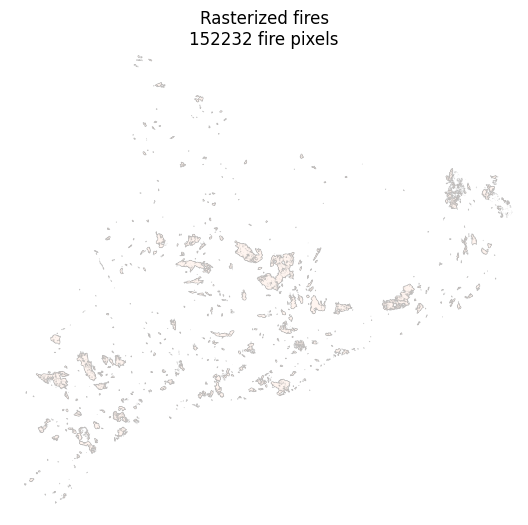

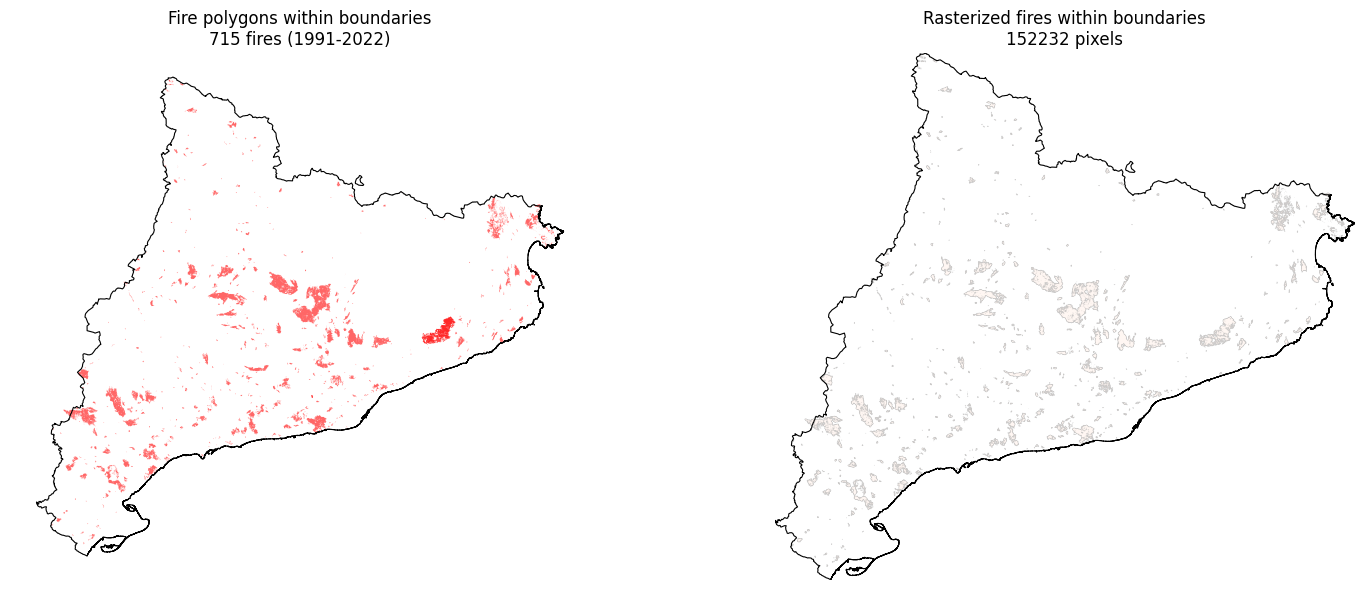

Quality control:
Fire raster values: [0. 1.]
Contains NaN: False
Fire coverage: 2.121%


In [8]:
fires_rasterized = rasterize_numerical_feature_fixed(fires_clean, reference_file, column=None)
fires_rasterized = np.nan_to_num(fires_rasterized, nan=0)

print(f"Fire rasterization complete!")
print(f"Fire pixels: {np.sum(fires_rasterized > 0)}")
print(f"Fire percentage: {100 * np.sum(fires_rasterized > 0) / fires_rasterized.size:.2f}%")

fig, ax = plt.subplots(figsize=(8, 6))
fire_display = np.where(fires_rasterized > 0, 1, np.nan)
ax.imshow(fire_display, cmap='Reds')
ax.set_title(f'Rasterized fires\n{np.sum(fires_rasterized > 0)} fire pixels')
ax.axis('off')
plt.show()

admin_boundaries = gpd.read_file("data_Catalonia/boundaries/Catalonia_adm_3035.shp")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

admin_boundaries.boundary.plot(ax=axes[0], color='black', linewidth=0.8)
fires_clean.plot(ax=axes[0], color='red', alpha=0.6, markersize=2)
axes[0].set_title(f'Fire polygons within boundaries\n{len(fires_clean)} fires (1991-2022)', fontsize=12)
axes[0].axis('off')

fire_display = np.where(fires_rasterized > 0, 1, np.nan)

with rasterio.open(reference_file) as src:
    bounds = src.bounds

extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
axes[1].imshow(fire_display, cmap='Reds', alpha=0.8, extent=extent)

admin_boundaries.boundary.plot(ax=axes[1], color='black', linewidth=0.8)

axes[1].set_xlim(bounds.left, bounds.right)
axes[1].set_ylim(bounds.bottom, bounds.top)

axes[1].set_title(f'Rasterized fires within boundaries\n{np.sum(fires_rasterized > 0)} pixels', fontsize=12)
axes[1].axis('off')

axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

print("Quality control:")
print(f"Fire raster values: {np.unique(fires_rasterized)}")
print(f"Contains NaN: {np.isnan(fires_rasterized).any()}")
print(f"Fire coverage: {100 * np.sum(fires_rasterized > 0) / fires_rasterized.size:.3f}%")

## Base susceptibility map

The base susceptibility model integrates fire proximity effects with environmental
factors to create a foundational risk map. Fire influence is modeled using
exponential distance decay, while environmental patterns simulate topographic
and climatic variations using trigonometric functions and controlled noise

Susceptibility map created
  Shape: (2554, 2810)
  Range: 0.000 - 1.000

Validation:
  Susceptibility at fire locations: 0.734
  Susceptibility elsewhere: 0.523
  Enhancement ratio: 1.40x

Susceptibility Statistics:
  Mean: 0.527
  Std: 0.192
  50th percentile: 0.530
  75th percentile: 0.662
  90th percentile: 0.794
  95th percentile: 0.852
Clipped susceptibility shape: (2554, 2810)
Original shape: (2554, 2810)
Valid pixels: 3210935

Clipped Susceptibility Statistics:
  Valid pixels: 3210935
  Mean: 0.643
  Std: 0.143
  Range: 0.302 - 1.000


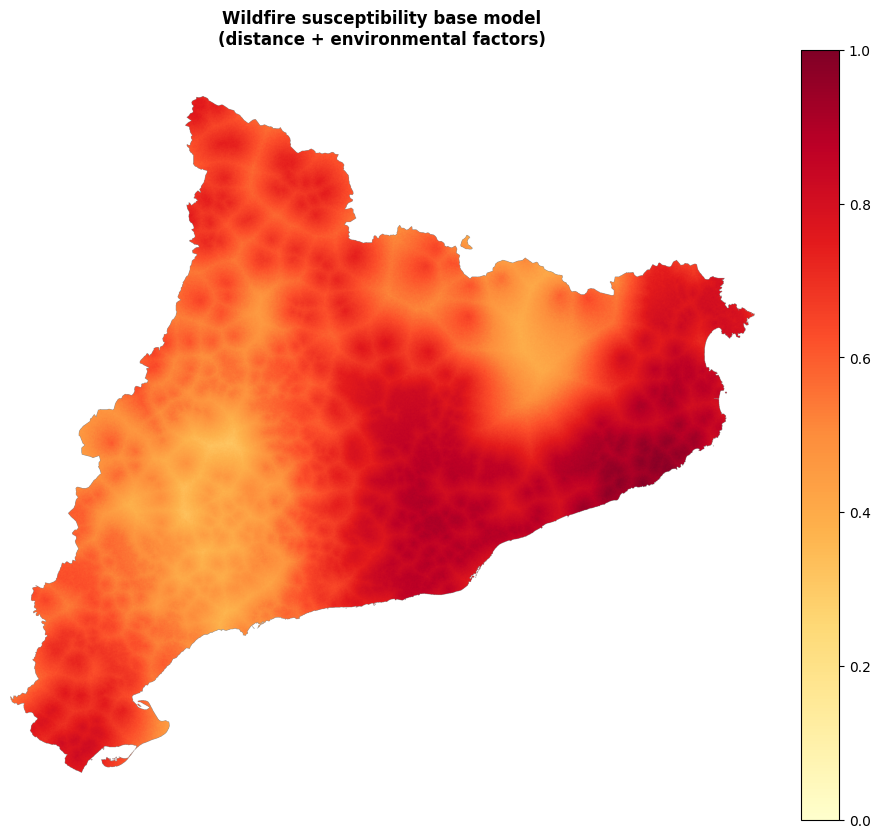

In [16]:
import shared_funcs

def create_susceptibility_from_fires(fires_data):
    """create susceptibility map combining fire proximity with environmental factors"""

    height, width = fires_data.shape

    # fire proximity influence w/ exponential decay
    fire_distance = distance_transform_edt(fires_data == 0)
    max_dist = np.max(fire_distance)
    fire_influence = np.exp(-fire_distance / (max_dist * 0.3))
    fire_influence = np.where(fires_data > 0, 1.0, fire_influence)

    # env patterns
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    X, Y = np.meshgrid(x, y)

    # simulated env factors
    elevation_pattern = 0.3 + 0.4 * np.sin(X * 2 * np.pi) * np.cos(Y * 1.5 * np.pi)
    climate_pattern = 0.2 + 0.5 * (0.7*X + 0.3*Y) + 0.2 * np.sin(X * 5 * np.pi)
    vegetation_pattern = 0.4 + 0.3 * np.cos(X * 1.5 * np.pi) * np.sin(Y * 2.5 * np.pi)

    # random env variation
    np.random.seed(42)
    random_noise = 0.3 * np.random.random((height, width))

    # combine
    environmental_factor = (0.3 * elevation_pattern +
                          0.3 * climate_pattern +
                          0.2 * vegetation_pattern +
                          0.2 * random_noise)

    # combine fire influence w/ environmental factors
    susceptibility = 0.3 * fire_influence + 0.7 * environmental_factor

    # smooth + normalize
    susceptibility = gaussian_filter(susceptibility, sigma=1.0)
    susc_min, susc_max = susceptibility.min(), susceptibility.max()
    if susc_max > susc_min:
        susceptibility = (susceptibility - susc_min) / (susc_max - susc_min)
    else:
        susceptibility = np.ones_like(susceptibility) * 0.5

    return susceptibility.astype(np.float32)

# create suscp map
original_susceptibility = create_susceptibility_from_fires(fires_rasterized)

print(f"Susceptibility map created")
print(f"  Shape: {original_susceptibility.shape}")
print(f"  Range: {original_susceptibility.min():.3f} - {original_susceptibility.max():.3f}")

# val against fire locations
fire_pixels = fires_rasterized > 0
if np.any(fire_pixels):
    fire_mean = np.mean(original_susceptibility[fire_pixels])
    non_fire_mean = np.mean(original_susceptibility[~fire_pixels])
    enhancement_ratio = fire_mean / non_fire_mean

    print(f"\nValidation:")
    print(f"  Susceptibility at fire locations: {fire_mean:.3f}")
    print(f"  Susceptibility elsewhere: {non_fire_mean:.3f}")
    print(f"  Enhancement ratio: {enhancement_ratio:.2f}x")

# create proper geographic mask for visualization
try:
    boundaries = gpd.read_file("data_Catalonia/boundaries/Catalonia_adm_3035.shp")

    with rasterio.open(reference_file) as src:
        ref = src.read(1)
        from rasterio.mask import mask as rio_mask

        shapes = boundaries.geometry.values
        masked_susc, transform = rio_mask(src, shapes, crop=False, invert=False, filled=True, nodata=-9999)

        ref = np.where(masked_susc[0] == -9999, -9999, ref)
        original_susceptibility_masked = np.where(masked_susc[0] == -9999, np.nan, original_susceptibility)

except:
    print("Using basic masking")
    with rasterio.open(reference_file) as src:
        ref = src.read(1)
        ref = np.where(ref == 0, -9999, ref)
        original_susceptibility_masked = original_susceptibility


shared_funcs.plot_raster_V2(
    original_susceptibility_masked,
    ref,
    cmap='YlOrRd',
    plot_kwargs={"vmin": 0, "vmax": 1.0},
    title="Wildfire susceptibility base model\n(distance + environmental factors)",
    figsize=(12, 10),
    dpi=100
)

# stats
valid_pixels = original_susceptibility[original_susceptibility >= 0.0]
print(f"\nSusceptibility Statistics:")
print(f"  Mean: {valid_pixels.mean():.3f}")
print(f"  Std: {valid_pixels.std():.3f}")
print(f"  50th percentile: {np.quantile(valid_pixels, 0.5):.3f}")
print(f"  75th percentile: {np.quantile(valid_pixels, 0.75):.3f}")
print(f"  90th percentile: {np.quantile(valid_pixels, 0.9):.3f}")
print(f"  95th percentile: {np.quantile(valid_pixels, 0.95):.3f}")

# clip
from rasterio.mask import mask as rio_mask

boundaries = gpd.read_file("data_Catalonia/boundaries/Catalonia_adm_3035.shp")

# clip suscp map to boundaries
with rasterio.open(reference_file) as src:

    profile = src.profile.copy()
    profile.update(dtype=original_susceptibility.dtype)

    shapes = boundaries.geometry.values

    # temp raster for masking
    import tempfile
    with tempfile.NamedTemporaryFile(suffix='.tif', delete=False) as tmp:
        tmp_path = tmp.name

    # write suscp to temp
    with rasterio.open(tmp_path, 'w', **profile) as dst:
        dst.write(original_susceptibility, 1)

    # mask
    with rasterio.open(tmp_path) as src_susc:
        clipped_susc, clipped_transform = rio_mask(
            src_susc,
            shapes,
            crop=True,
            invert=False,
            filled=True,
            nodata=np.nan
        )

    # clean up
    import os
    os.unlink(tmp_path)

# extract the clipped array
original_susceptibility_clipped = clipped_susc[0]

print(f"Clipped susceptibility shape: {original_susceptibility_clipped.shape}")
print(f"Original shape: {original_susceptibility.shape}")
print(f"Valid pixels: {np.sum(~np.isnan(original_susceptibility_clipped))}")

# stats
valid_clipped_pixels = original_susceptibility_clipped[~np.isnan(original_susceptibility_clipped)]
print(f"\nClipped Susceptibility Statistics:")
print(f"  Valid pixels: {len(valid_clipped_pixels)}")
print(f"  Mean: {valid_clipped_pixels.mean():.3f}")
print(f"  Std: {valid_clipped_pixels.std():.3f}")
print(f"  Range: {valid_clipped_pixels.min():.3f} - {valid_clipped_pixels.max():.3f}")

original_susceptibility = original_susceptibility_clipped

# 03. ResNet + FPN

This section implements deep learning-based feature enhancement using a pre-trained ResNet backbone with Feature Pyramid Network (FPN). The approach extracts multi-scale
spatial features from the susceptibility map and combines them to create enhanced representations that better capture spatial patterns relevant to fire risk.

The ResNet backbone (pre-trained on ImageNet) provides feature extraction capabilities, while the FPN enables multi-scale feature fusion. The enhancement process converts susceptibility maps to RGB format, applies ImageNet normalization, extracts features at multiple pyramid levels, and blends the enhanced features with the original susceptibility values.

Using device: cpu
ResNet+FPN enhancement complete!
Enhanced shape: (2554, 2810)
Valid pixels: 3210935

Fire location validation:
  Original - Fire: 0.734, Other: 0.639, Ratio: 1.15x
  Enhanced - Fire: 0.575, Other: 0.491, Ratio: 1.17x
  Improvement: 1.02x better discrimination


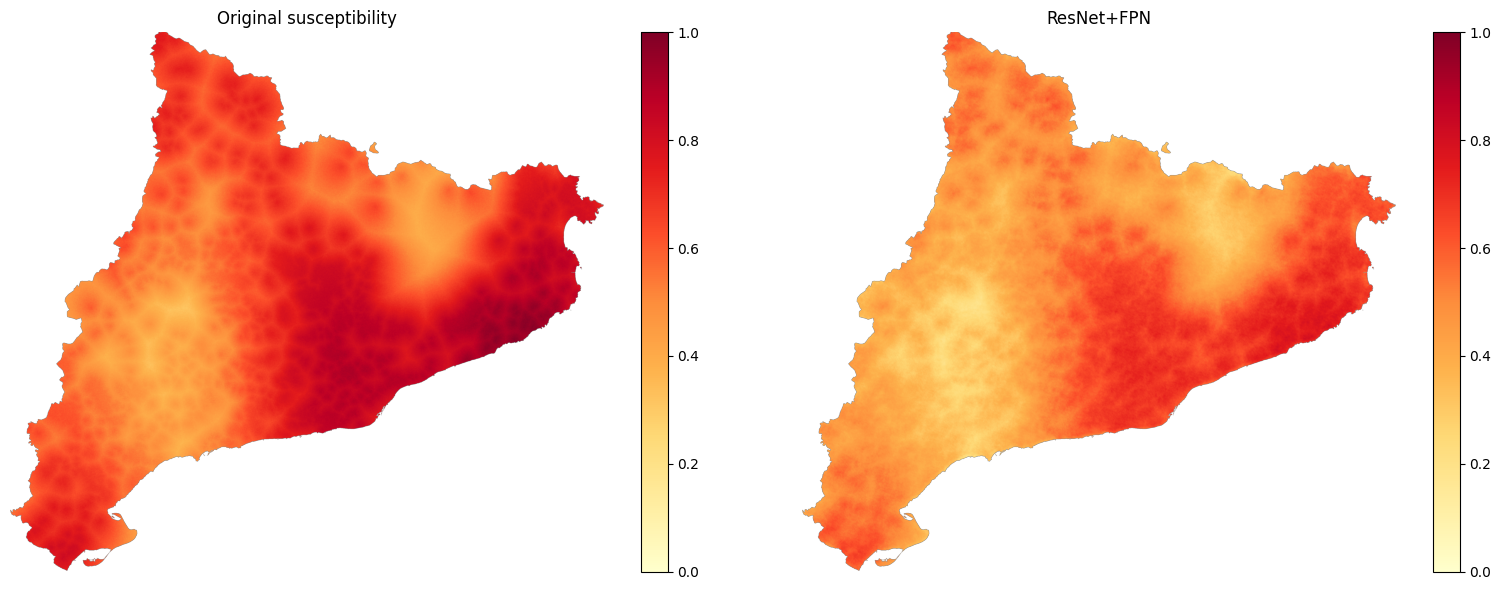

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights, ResNet101_Weights

device = torch.device('cpu')
print(f"Using device: {device}")

class SimpleFPN(nn.Module):
    def __init__(self, backbone_channels, fpn_channels=256):
        super(SimpleFPN, self).__init__()
        self.fpn_channels = fpn_channels

        # lateral convolutions
        self.lateral_convs = nn.ModuleList()
        for channels in backbone_channels:
            self.lateral_convs.append(nn.Conv2d(channels, fpn_channels, kernel_size=1))

        # tp down convolutions
        self.fpn_convs = nn.ModuleList()
        for _ in range(len(backbone_channels)):
            self.fpn_convs.append(nn.Conv2d(fpn_channels, fpn_channels, kernel_size=3, padding=1))

    def forward(self, features):

        laterals = [lateral_conv(feature) for feature, lateral_conv in zip(features, self.lateral_convs)]


        fpn_features = []
        prev_feature = laterals[-1]
        fpn_features.append(self.fpn_convs[-1](prev_feature))

        for i in range(len(laterals) - 2, -1, -1):
            upsampled = F.interpolate(prev_feature, size=laterals[i].shape[-2:], mode='bilinear', align_corners=False)
            merged = laterals[i] + upsampled
            fpn_feature = self.fpn_convs[i](merged)
            fpn_features.insert(0, fpn_feature)
            prev_feature = merged

        return fpn_features

class ResNetFeatureExtractor(nn.Module):
    def __init__(self, backbone_name='resnet50', pretrained=True):
        super(ResNetFeatureExtractor, self).__init__()

        if backbone_name == 'resnet50':
            weights = ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
            backbone = models.resnet50(weights=weights)
        elif backbone_name == 'resnet101':
            weights = ResNet101_Weights.IMAGENET1K_V2 if pretrained else None
            backbone = models.resnet101(weights=weights)
        else:
            raise ValueError(f"Unsupported backbone: {backbone_name}")

        self.conv1 = backbone.conv1
        self.bn1 = backbone.bn1
        self.relu = backbone.relu
        self.maxpool = backbone.maxpool
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        self.feature_channels = [256, 512, 1024, 2048]

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        c2 = self.layer1(x)
        c3 = self.layer2(c2)
        c4 = self.layer3(c3)
        c5 = self.layer4(c4)

        return [c2, c3, c4, c5]

class ResNetFPN(nn.Module):
    def __init__(self, backbone_name='resnet50', fpn_channels=256, num_levels=4):
        super(ResNetFPN, self).__init__()

        self.backbone = ResNetFeatureExtractor(backbone_name, pretrained=True)
        self.fpn = SimpleFPN(self.backbone.feature_channels, fpn_channels)

        self.fusion_convs = nn.ModuleList()
        for _ in range(num_levels):
            self.fusion_convs.append(
                nn.Sequential(
                    nn.Conv2d(fpn_channels, 64, kernel_size=3, padding=1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(64, 1, kernel_size=1)
                )
            )

        self.num_levels = num_levels

    def forward(self, x):
        backbone_features = self.backbone(x)
        fpn_features = self.fpn(backbone_features)
        target_size = x.shape[-2:]

        enhanced_features = []
        for i, (fpn_feat, fusion_conv) in enumerate(zip(fpn_features, self.fusion_convs)):
            processed = fusion_conv(fpn_feat)
            resized = F.interpolate(processed, size=target_size, mode='bilinear', align_corners=False)
            enhanced_features.append(resized)

        return enhanced_features

def enhance_susceptibility_with_resnet_fpn(
    susceptibility_map,
    backbone_name='resnet50',
    fpn_channels=256,
    feature_levels=[0, 1, 2, 3],
    level_weights=None,
    resnet_influence=0.4
):
    if level_weights is None:
        level_weights = [0.4, 0.3, 0.2, 0.1]

    level_weights = np.array(level_weights)
    level_weights = level_weights / level_weights.sum()

    # initialise model
    model = ResNetFPN(backbone_name=backbone_name, fpn_channels=fpn_channels, num_levels=4)
    model.eval()

    # handle nan
    valid_mask = ~np.isnan(susceptibility_map)
    if not np.any(valid_mask):
        print("Warning: All values are NaN!")
        return susceptibility_map

    # fill nan w mean of valid pixels
    susc_filled = susceptibility_map.copy()
    susc_filled[~valid_mask] = np.nanmean(susceptibility_map)

    # normalize
    susc_min, susc_max = np.nanmin(susceptibility_map), np.nanmax(susceptibility_map)
    if susc_max > susc_min:
        susc_norm = (susc_filled - susc_min) / (susc_max - susc_min)
    else:
        susc_norm = np.ones_like(susc_filled) * 0.5

    # rgb input
    rgb_input = np.stack([susc_norm, susc_norm, susc_norm], axis=0)
    input_tensor = torch.FloatTensor(rgb_input).unsqueeze(0)

    # normalization
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    input_normalized = normalize(input_tensor)

    # extract features
    with torch.no_grad():
        fpn_features = model(input_normalized)

    # combine selected FPN levels
    enhanced_features = None
    total_weight = 0

    for level_idx in feature_levels:
        if level_idx < len(fpn_features):
            feature_map = fpn_features[level_idx].squeeze().cpu().numpy()

            if feature_map.max() > feature_map.min():
                feature_norm = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
            else:
                feature_norm = np.ones_like(feature_map) * 0.5

            weight = level_weights[level_idx] if level_idx < len(level_weights) else 0.1

            if enhanced_features is None:
                enhanced_features = feature_norm * weight
            else:
                enhanced_features += feature_norm * weight

            total_weight += weight

    if total_weight > 0:
        enhanced_features /= total_weight
    else:
        enhanced_features = susc_norm

    # combine w/ original
    final_enhanced = (1 - resnet_influence) * susc_norm + resnet_influence * enhanced_features
    final_enhanced = np.clip(final_enhanced, 0, 1)

    # restore nan values where they were originally
    final_enhanced[~valid_mask] = np.nan

    return final_enhanced.astype(np.float32)

# apply ResNet+FPN enhancement

enhanced_susceptibility_resnet = enhance_susceptibility_with_resnet_fpn(
    original_susceptibility,
    backbone_name='resnet50',
    fpn_channels=256,
    feature_levels=[0, 1, 2, 3],
    level_weights=[0.4, 0.3, 0.2, 0.1],
    resnet_influence=0.4
)

print(f"ResNet+FPN enhancement complete!")
print(f"Enhanced shape: {enhanced_susceptibility_resnet.shape}")
print(f"Valid pixels: {np.sum(~np.isnan(enhanced_susceptibility_resnet))}")

# validation against fire locations -- only on valid pixels
valid_mask = ~np.isnan(enhanced_susceptibility_resnet)
fire_pixels_valid = (fires_rasterized > 0) & valid_mask

if np.any(fire_pixels_valid):
    original_fire_mean = np.nanmean(original_susceptibility[fire_pixels_valid])
    enhanced_fire_mean = np.nanmean(enhanced_susceptibility_resnet[fire_pixels_valid])

    original_other_mean = np.nanmean(original_susceptibility[~fire_pixels_valid & valid_mask])
    enhanced_other_mean = np.nanmean(enhanced_susceptibility_resnet[~fire_pixels_valid & valid_mask])

    if original_other_mean > 0 and enhanced_other_mean > 0:
        original_ratio = original_fire_mean / original_other_mean
        enhanced_ratio = enhanced_fire_mean / enhanced_other_mean

        print(f"\nFire location validation:")
        print(f"  Original - Fire: {original_fire_mean:.3f}, Other: {original_other_mean:.3f}, Ratio: {original_ratio:.2f}x")
        print(f"  Enhanced - Fire: {enhanced_fire_mean:.3f}, Other: {enhanced_other_mean:.3f}, Ratio: {enhanced_ratio:.2f}x")
        print(f"  Improvement: {enhanced_ratio/original_ratio:.2f}x better discrimination")


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

im1 = axes[0].imshow(original_susceptibility, cmap='YlOrRd', vmin=0, vmax=1)
axes[0].set_title('Original susceptibility')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046)

im2 = axes[1].imshow(enhanced_susceptibility_resnet, cmap='YlOrRd', vmin=0, vmax=1)
axes[1].set_title('ResNet+FPN')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046)

# add fire contours to both plots
fire_contour = np.where(fires_rasterized > 0, 1, np.nan)
for ax in axes:
    ax.contour(fire_contour, levels=[0.5], colors='red', linewidths=1.5, alpha=0.8)

plt.tight_layout()
plt.show()

# update var
enhanced_susceptibility = enhanced_susceptibility_resnet.copy()

# 04. OBIA / burn severity classification

This section transforms the ResNet+FPN enhanced susceptibility map into burn severity classes. Rather
than using complex segmentation approaches, I apply direct threshold-based classification to create five distinct severity levels: very low, low, moderate, high, and extreme.

The classification process includes:
1. Threshold-based classification using user-defined boundaries
2. Gaussian smoothing for spatial coherence
3. Morphological operations to remove small isolated patches
4. Neighborhood-based reassignment of cleaned pixels
5. Comprehensive validation against historical fire locations

The resulting classification outputs fire risk zones.

Applying classification with boundaries: [0.2, 0.4, 0.6, 0.8, 1.0]


/usr/local/lib/python3.12/dist-packages/numpy/_core/numeric.py:452: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


Applying morphological cleanup (min patch size: 25)
Classification complete!
  Total classified pixels: 3,210,953
  Class 1 (Very low): 1,708 pixels (0.1%)
  Class 2 (Low): 814,096 pixels (25.4%)
  Class 3 (Moderate): 1,617,264 pixels (50.4%)
  Class 4 (High): 777,702 pixels (24.2%)
  Class 5 (Extreme): 183 pixels (0.0%)
Classification processing complete!

Fire location validation:
  Very low (Class 1): 0 fire pixels (0.0% of all fires)
  Low (Class 2): 11,587 fire pixels (7.7% of all fires)
  Moderate (Class 3): 61,374 fire pixels (40.6% of all fires)
  High (Class 4): 78,310 fire pixels (51.8% of all fires)
  Extreme (Class 5): 0 fire pixels (0.0% of all fires)


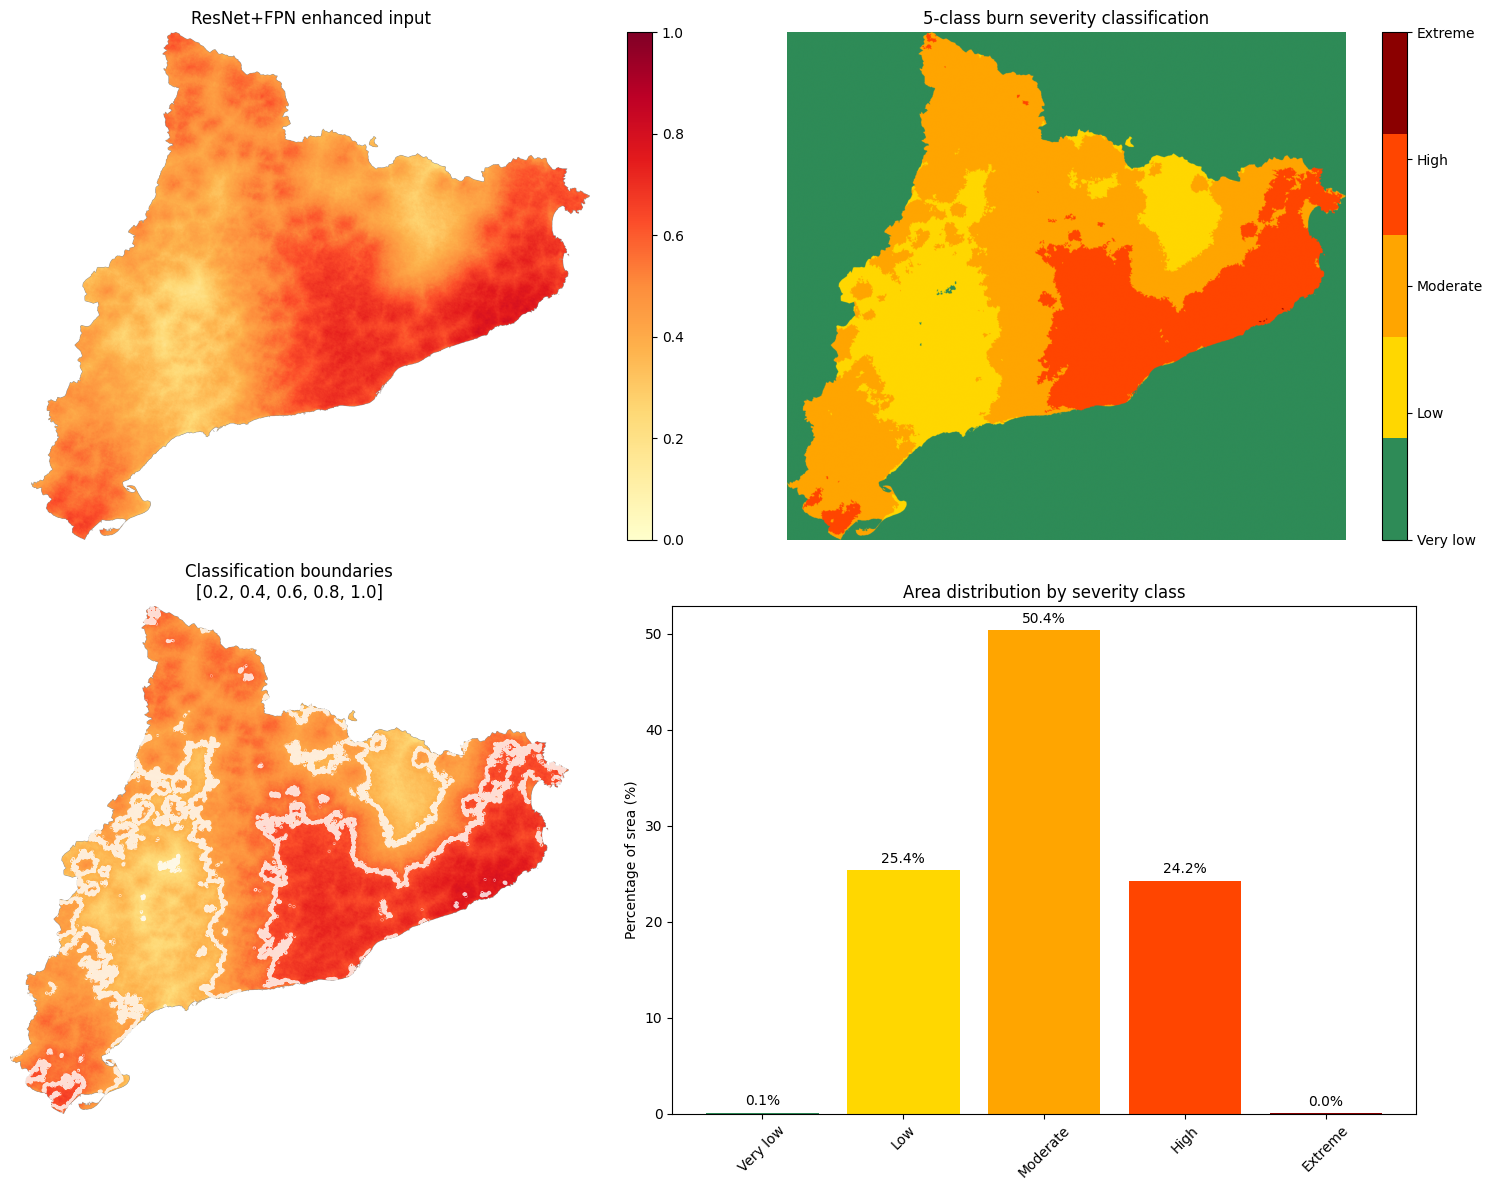


Classification performance assessment:
  High + extreme classes contain: 51.8% of fires
  High + extreme classes cover: 24.2% of area
  Fire concentration index: 2.14x
  Assessment: Good fire discrimination (index > 1.5)

  Management interpretation:
    - Good: 50-70% of fires in high-risk areas


In [20]:
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, remove_small_holes
from scipy import ndimage
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def apply_burn_severity_classification(
    input_map,
    class_boundaries=[0.2, 0.4, 0.6, 0.8, 1.0],
    smoothing_sigma=0.8,
    min_patch_size=25
):
    """
    Apply 5-class burn severity classification to susceptibility map

    Args:
        input_map: input susceptibility array (0-1 range)
        class_boundaries: list of 5 threshold values defining class boundaries
        smoothing_sigma: gaussian smoothing parameter (0 = no smoothing)
        min_patch_size: minimum patch size in pixels

    Returns:
        dict with classified_map, class_stats, and processing info
    """

    # handle nan values
    valid_mask = ~np.isnan(input_map)
    if not np.any(valid_mask):
        print("Warning: No valid pixels for classification")
        return {'classified_map': np.full_like(input_map, np.nan), 'class_stats': {}, 'n_pixels': {}}

    # boundaries check
    boundaries = sorted([b for b in class_boundaries if 0 <= b <= 1])
    if len(boundaries) < 4:
        print("Warning: Need at least 4 boundaries for 5 classes, using defaults")
        boundaries = [0.2, 0.4, 0.6, 0.8, 1.0]

    print(f"Applying classification with boundaries: {boundaries}")

    # 1 - apply smoothing to input if requested
    working_map = input_map.copy()
    if smoothing_sigma > 0:
        # only smooth valid areas
        if np.any(valid_mask):
            temp_map = working_map.copy()
            temp_map[~valid_mask] = np.nanmean(working_map)
            smoothed = gaussian(temp_map, sigma=smoothing_sigma)
            working_map[valid_mask] = smoothed[valid_mask]

    # 2 - apply classification thresholds
    classified_map = np.full_like(working_map, np.nan, dtype=np.int32)

    # class 1 - v low (0 - 1st boundary)
    class_1_mask = (working_map >= 0) & (working_map < boundaries[0]) & valid_mask
    classified_map[class_1_mask] = 1

    # class 2 - low (1st - 2nd boundary)
    class_2_mask = (working_map >= boundaries[0]) & (working_map < boundaries[1]) & valid_mask
    classified_map[class_2_mask] = 2

    # class 3 - moderate (2nd - 3rd boundary)
    class_3_mask = (working_map >= boundaries[1]) & (working_map < boundaries[2]) & valid_mask
    classified_map[class_3_mask] = 3

    # class 4 - high (3rd - 4th boundary)
    class_4_mask = (working_map >= boundaries[2]) & (working_map < boundaries[3]) & valid_mask
    classified_map[class_4_mask] = 4

    # class 5 - extreme (4th - 1.0)
    class_5_mask = (working_map >= boundaries[3]) & (working_map <= 1.0) & valid_mask
    classified_map[class_5_mask] = 5

    # 3 - apply morphological cleanup if requested
    if min_patch_size > 0:
        print(f"Applying morphological cleanup (min patch size: {min_patch_size})")

        for class_id in range(1, 6):
            class_mask = classified_map == class_id

            if np.any(class_mask):
                cleaned_mask = remove_small_objects(class_mask, min_size=min_patch_size)

                # Fill small holes within large patches
                filled_mask = remove_small_holes(cleaned_mask, area_threshold=min_patch_size//2)

                # update classification
                # pixels removed from this class become unclassified temporarily
                removed_pixels = class_mask & ~filled_mask
                classified_map[removed_pixels] = 0  # Temporary unclassified

                # update w/ cleaned mask
                classified_map[filled_mask] = class_id

        # reassign unclassified pixels (class 0) to nearest neighbor class
        unclassified = classified_map == 0
        if np.any(unclassified):
            # for each unclassified pixel, assign to the most common class in its neighborhood
            for i in range(classified_map.shape[0]):
                for j in range(classified_map.shape[1]):
                    if unclassified[i, j]:
                        # 5x5 neighborhood
                        i_start, i_end = max(0, i-2), min(classified_map.shape[0], i+3)
                        j_start, j_end = max(0, j-2), min(classified_map.shape[1], j+3)

                        neighborhood = classified_map[i_start:i_end, j_start:j_end]
                        valid_neighbors = neighborhood[(neighborhood > 0) & (neighborhood <= 5)]

                        if len(valid_neighbors) > 0:
                            # assign most common class in neighborhood
                            unique_classes, counts = np.unique(valid_neighbors, return_counts=True)
                            most_common_class = unique_classes[np.argmax(counts)]
                            classified_map[i, j] = most_common_class
                        else:
                            # fallback to class based on original susceptibility value
                            orig_val = working_map[i, j]
                            if not np.isnan(orig_val):
                                for k, boundary in enumerate(boundaries):
                                    if orig_val < boundary:
                                        classified_map[i, j] = k + 1
                                        break
                                else:
                                    classified_map[i, j] = 5

    # 4 - stats
    class_names = ['Very low', 'Low', 'Moderate', 'High', 'Extreme']
    class_stats = {}
    n_pixels = {}

    valid_classified = ~np.isnan(classified_map) & (classified_map > 0)
    total_valid_pixels = np.sum(valid_classified)

    for class_id in range(1, 6):
        class_mask = classified_map == class_id
        n_class_pixels = np.sum(class_mask)

        class_stats[class_id] = {
            'name': class_names[class_id - 1],
            'n_pixels': n_class_pixels,
            'percentage': (n_class_pixels / total_valid_pixels * 100) if total_valid_pixels > 0 else 0,
            'mean_susceptibility': np.nanmean(working_map[class_mask]) if n_class_pixels > 0 else 0,
            'min_susceptibility': np.nanmin(working_map[class_mask]) if n_class_pixels > 0 else 0,
            'max_susceptibility': np.nanmax(working_map[class_mask]) if n_class_pixels > 0 else 0
        }

        n_pixels[class_id] = n_class_pixels

    print(f"Classification complete!")
    print(f"  Total classified pixels: {total_valid_pixels:,}")
    for class_id in range(1, 6):
        stats = class_stats[class_id]
        print(f"  Class {class_id} ({stats['name']}): {stats['n_pixels']:,} pixels ({stats['percentage']:.1f}%)")

    return {
        'classified_map': classified_map.astype(np.float32),
        'smoothed_input': working_map,
        'class_stats': class_stats,
        'n_pixels': n_pixels,
        'boundaries': boundaries,
        'total_valid_pixels': total_valid_pixels
    }

# apply burn severity classification to ResNet+FPN enhanced susceptibility

classification_result = apply_burn_severity_classification(
    enhanced_susceptibility,
    class_boundaries=[0.2, 0.4, 0.6, 0.8, 1.0],
    smoothing_sigma=0.8,
    min_patch_size=25
)

classified_susceptibility = classification_result['classified_map']
class_stats = classification_result['class_stats']
boundaries_used = classification_result['boundaries']

print(f"Classification processing complete!")

# Fire location validation

"""
Validate classification performance by analyzing how historical fire locations
are distributed across the severity classes
"""

# validation against fire locations
valid_mask = ~np.isnan(classified_susceptibility) & (classified_susceptibility > 0)
fire_pixels_valid = (fires_rasterized > 0) & valid_mask

if np.any(fire_pixels_valid):
    print(f"\nFire location validation:")

    # count fires in each severity class
    fire_class_distribution = {}
    for class_id in range(1, 6):
        class_mask = classified_susceptibility == class_id
        fires_in_class = np.sum(fire_pixels_valid & class_mask)
        total_fires = np.sum(fire_pixels_valid)

        fire_class_distribution[class_id] = {
            'fire_pixels': fires_in_class,
            'percentage_of_fires': (fires_in_class / total_fires * 100) if total_fires > 0 else 0
        }

        class_name = class_stats[class_id]['name']
        print(f"  {class_name} (Class {class_id}): {fires_in_class:,} fire pixels ({fire_class_distribution[class_id]['percentage_of_fires']:.1f}% of all fires)")

# vis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

severity_colors = ['#2E8B57', '#FFD700', '#FFA500', '#FF4500', '#8B0000']
severity_cmap = ListedColormap(severity_colors)

im1 = axes[0,0].imshow(enhanced_susceptibility, cmap='YlOrRd', vmin=0, vmax=1)
axes[0,0].set_title('ResNet+FPN enhanced input')
axes[0,0].axis('off')
plt.colorbar(im1, ax=axes[0,0], fraction=0.046)

im2 = axes[0,1].imshow(classified_susceptibility, cmap=severity_cmap, vmin=1, vmax=5)
axes[0,1].set_title('5-class burn severity classification')
axes[0,1].axis('off')
cbar2 = plt.colorbar(im2, ax=axes[0,1], fraction=0.046)
cbar2.set_ticks([1, 2, 3, 4, 5])
cbar2.set_ticklabels(['Very low', 'Low', 'Moderate', 'High', 'Extreme'])

axes[1,0].imshow(enhanced_susceptibility, cmap='YlOrRd', vmin=0, vmax=1)

for i, boundary in enumerate(boundaries_used[:-1]):
    axes[1,0].contour(enhanced_susceptibility, levels=[boundary],
                     colors='white', linewidths=2, alpha=0.8)

axes[1,0].set_title(f'Classification boundaries\n{boundaries_used}')
axes[1,0].axis('off')


class_names = [class_stats[i]['name'] for i in range(1, 6)]
class_percentages = [class_stats[i]['percentage'] for i in range(1, 6)]
colors = severity_colors

bars = axes[1,1].bar(class_names, class_percentages, color=colors)
axes[1,1].set_title('Area distribution by severity class')
axes[1,1].set_ylabel('Percentage of srea (%)')
axes[1,1].tick_params(axis='x', rotation=45)

# add % labels on bars
for bar, pct in zip(bars, class_percentages):
    height = bar.get_height()
    axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{pct:.1f}%', ha='center', va='bottom')

fire_contour = np.where(fires_rasterized > 0, 1, np.nan)
for i in range(2):
    for j in range(2):
        if i < 1 or j < 1:
            axes[i,j].contour(fire_contour, levels=[0.5], colors='red', linewidths=1, alpha=0.8)

plt.tight_layout()
plt.show()

# Classification perf assessment

if np.any(fire_pixels_valid):
    # calc fire concentration in high-risk classes
    high_extreme_fires = (fire_class_distribution[4]['fire_pixels'] +
                         fire_class_distribution[5]['fire_pixels'])
    high_extreme_percentage = (high_extreme_fires / np.sum(fire_pixels_valid) * 100)

    high_extreme_area = (class_stats[4]['percentage'] + class_stats[5]['percentage'])

    # fire concentration index (higher = better discrimination)
    if high_extreme_area > 0:
        concentration_index = high_extreme_percentage / high_extreme_area

        print(f"\nClassification performance assessment:")
        print(f"  High + extreme classes contain: {high_extreme_percentage:.1f}% of fires")
        print(f"  High + extreme classes cover: {high_extreme_area:.1f}% of area")
        print(f"  Fire concentration index: {concentration_index:.2f}x")


        if concentration_index > 1.5:
            print(f"  Assessment: Good fire discrimination (index > 1.5)")
        elif concentration_index > 1.2:
            print(f"  Assessment: Moderate discrimination (index 1.2-1.5)")
        else:
            print(f"  Assessment: Limited discrimination (index < 1.2)")

        # Management recommendations
        print(f"\n  Management interpretation:")
        if high_extreme_percentage > 70:
            print(f"    - Excellent: >70% of fires in high-risk areas")
        elif high_extreme_percentage > 50:
            print(f"    - Good: 50-70% of fires in high-risk areas")
        else:
            print(f"    - Consider adjusting boundaries: <50% of fires in high-risk areas")


# 05. Interactive interface

This section implements a web-based interface using Gradio for burn severity classification parameters. I wanted to
create something similar to the eCognition GUI but in a web-accessible format that could make these capabilities
available in an open-source environment.

The interface allows users to adjust classification boundaries, spatial processing parameters, and visualization options while providing immediate feedback on classification performance and fire location validation.

Since I had no prior experience with Gradio, I used AI assistance to implement the interface components and ensure proper functionality. The system provides three key parameter categories: class boundary thresholds, spatial processing
controls, and visualization options

In [21]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.colors import ListedColormap
import io

# Global variables for the interface
global_resnet_susc = enhanced_susceptibility.copy()
global_fires = fires_rasterized.copy()

def process_burn_severity_classification(
    # Class boundary parameters
    boundary_1, boundary_2, boundary_3, boundary_4, boundary_5,
    # Spatial processing parameters
    smoothing_sigma, min_patch_size,
    # Visualization options
    show_boundaries, show_distribution, show_fire_overlay
):
    """
    Interactive burn severity classification with real-time updates
    """
    try:
        # Ensure boundaries are properly ordered
        boundaries = sorted([boundary_1, boundary_2, boundary_3, boundary_4, boundary_5])
        boundaries = [max(0.0, min(1.0, b)) for b in boundaries]  # Clamp to valid range

        # Apply classification
        classification_result = apply_burn_severity_classification(
            global_resnet_susc,
            class_boundaries=boundaries,
            smoothing_sigma=smoothing_sigma,
            min_patch_size=int(min_patch_size)
        )

        classified_map = classification_result['classified_map']
        class_stats = classification_result['class_stats']
        smoothed_input = classification_result['smoothed_input']

        # Determine number of plots
        n_plots = 2  # Always show input and classified output
        if show_boundaries: n_plots += 1
        if show_distribution: n_plots += 1

        # Create subplot layout
        if n_plots <= 2:
            fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        elif n_plots == 3:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        else:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        if n_plots == 1:
            axes = [axes]
        elif n_plots <= 4:
            axes = axes.flatten()

        plot_idx = 0

        # Define colors for severity classes
        severity_colors = ['#2E8B57', '#FFD700', '#FFA500', '#FF4500', '#8B0000']
        severity_cmap = ListedColormap(severity_colors)

        # Plot 1: Enhanced input
        im1 = axes[plot_idx].imshow(smoothed_input if smoothing_sigma > 0 else global_resnet_susc,
                                   cmap='YlOrRd', vmin=0, vmax=1)
        title = f'ResNet+FPN input'
        if smoothing_sigma > 0:
            title += f'\n(σ={smoothing_sigma:.1f})'
        axes[plot_idx].set_title(title, fontsize=11)
        axes[plot_idx].axis('off')
        plt.colorbar(im1, ax=axes[plot_idx], fraction=0.046, pad=0.04)
        plot_idx += 1

        # Plot 2: Classified output
        im2 = axes[plot_idx].imshow(classified_map, cmap=severity_cmap, vmin=1, vmax=5)
        axes[plot_idx].set_title(f'5 class burn severity\n(Min patch: {int(min_patch_size)} px)', fontsize=11)
        axes[plot_idx].axis('off')
        cbar2 = plt.colorbar(im2, ax=axes[plot_idx], fraction=0.046, pad=0.04)
        cbar2.set_ticks([1, 2, 3, 4, 5])
        cbar2.set_ticklabels(['Very low', 'Low', 'Mod', 'High', 'Extreme'], fontsize=9)
        plot_idx += 1

        # Plot 3: Boundary visualization (optional)
        if show_boundaries and plot_idx < len(axes):
            axes[plot_idx].imshow(global_resnet_susc, cmap='YlOrRd', vmin=0, vmax=1, alpha=0.7)

            # Add boundary contours
            colors = ['white', 'cyan', 'yellow', 'orange']
            for i, boundary in enumerate(boundaries[:-1]):  # Skip last boundary (1.0)
                if i < len(colors):
                    axes[plot_idx].contour(global_resnet_susc, levels=[boundary],
                                         colors=[colors[i]], linewidths=2, alpha=0.9)

            axes[plot_idx].set_title(f'Class boundaries\n{[f"{b:.2f}" for b in boundaries]}', fontsize=10)
            axes[plot_idx].axis('off')
            plot_idx += 1

        # Plot 4: Class distribution (optional)
        if show_distribution and plot_idx < len(axes):
            class_names = ['Very low', 'Low', 'Moderate', 'High', 'Extreme']
            class_percentages = [class_stats[i]['percentage'] for i in range(1, 6)]

            bars = axes[plot_idx].bar(range(5), class_percentages, color=severity_colors)
            axes[plot_idx].set_title('Area distribution', fontsize=11)
            axes[plot_idx].set_ylabel('Area (%)', fontsize=10)
            axes[plot_idx].set_xticks(range(5))
            axes[plot_idx].set_xticklabels(['VL', 'L', 'M', 'H', 'E'], fontsize=9)

            # Add percentage labels
            for i, (bar, pct) in enumerate(zip(bars, class_percentages)):
                if pct > 2:  # Only show label if bar is tall enough
                    axes[plot_idx].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.5,
                                       f'{pct:.1f}%', ha='center', va='bottom', fontsize=8)
            plot_idx += 1

        # Add fire overlays to spatial plots
        if show_fire_overlay:
            fire_contour = np.where(global_fires > 0, 1, np.nan)
            for i in range(min(plot_idx, len(axes))):
                # Only add to spatial plots (not bar chart)
                if i < 3 or (i == 3 and not show_distribution):
                    axes[i].contour(fire_contour, levels=[0.5], colors='red', linewidths=1, alpha=0.8)

        # Hide unused subplots
        for i in range(plot_idx, len(axes)):
            axes[i].set_visible(False)

        plt.tight_layout()

        # Convert to PIL Image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight', facecolor='white')
        buf.seek(0)
        pil_image = Image.open(buf)
        plt.close()

        # Generate fire validation statistics
        valid_mask = ~np.isnan(classified_map) & (classified_map > 0)
        fire_pixels_valid = (global_fires > 0) & valid_mask

        if np.any(fire_pixels_valid):
            total_fires = np.sum(fire_pixels_valid)

            fire_stats_text = "**Fire location validation:**\n"
            for class_id in range(1, 6):
                class_mask = classified_map == class_id
                fires_in_class = np.sum(fire_pixels_valid & class_mask)
                fire_percentage = (fires_in_class / total_fires * 100) if total_fires > 0 else 0
                area_percentage = class_stats[class_id]['percentage']

                class_name = class_stats[class_id]['name']
                fire_stats_text += f"- **{class_name}**: {fire_percentage:.1f}% of fires, {area_percentage:.1f}% of area\n"

            # Calculate fire concentration index (higher = better discrimination)
            high_severity_fires = np.sum(fire_pixels_valid & ((classified_map == 4) | (classified_map == 5)))
            high_severity_percentage = (high_severity_fires / total_fires * 100) if total_fires > 0 else 0

            stats_text = f"""
**Classification results:**
- **Boundaries**: {[f"{b:.2f}" for b in boundaries]}
- **Total classified area**: {classification_result['total_valid_pixels']:,} pixels
- **Smoothing**: σ = {smoothing_sigma:.1f}
- **Min patch size**: {int(min_patch_size)} pixels

**Class distribution:**
{chr(10).join([f"- **{class_stats[i]['name']}**: {class_stats[i]['percentage']:.1f}%" for i in range(1, 6)])}

{fire_stats_text}

**Fire risk assessment:**
- **High + extreme severity areas contain {high_severity_percentage:.1f}% of historical fires**
- **Fire concentration index**: {high_severity_percentage/sum([class_stats[4]['percentage'], class_stats[5]['percentage']]):.2f}x
            """
        else:
            stats_text = f"""
**Classification results:**
- **Boundaries**: {[f"{b:.2f}" for b in boundaries]}
- **Total area**: {classification_result['total_valid_pixels']:,} pixels
- **Class distribution**: {', '.join([f"{class_stats[i]['name']}: {class_stats[i]['percentage']:.1f}%" for i in range(1, 6)])}
            """

        return pil_image, stats_text

    except Exception as e:
        # Error handling
        error_fig, ax = plt.subplots(figsize=(8, 6))
        ax.text(0.5, 0.5, f"Classification error:\n{str(e)}",
                ha='center', va='center', fontsize=12, color='red')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')

        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100, bbox_inches='tight')
        buf.seek(0)
        error_image = Image.open(buf)
        plt.close()

        return error_image, f"Error: {str(e)}"

def create_burn_severity_interface():
    """
    Create the interactive burn severity classification interface
    """
    with gr.Blocks(title="Burn severity classification", theme=gr.themes.Soft()) as demo:
        gr.Markdown("""
        # Wildfire Burn Severity Classification
        **Interactive 5-class burn severity mapping from ResNet+FPN enhanced susceptibility**

        Adjust the three key parameters below. Red contours show historical fire locations for validation.
        """)

        with gr.Row():
            # Left column: Class boundaries
            with gr.Column(scale=1):
                gr.Markdown("### Class boundary thresholds")
                gr.Markdown("*Set the susceptibility values that define each severity class*")

                boundary_1 = gr.Slider(0.05, 0.4, step=0.02, value=0.2, label="Very low → Low")
                boundary_2 = gr.Slider(0.2, 0.6, step=0.02, value=0.4, label="Low → Moderate")
                boundary_3 = gr.Slider(0.4, 0.8, step=0.02, value=0.6, label="Moderate → High")
                boundary_4 = gr.Slider(0.6, 0.95, step=0.02, value=0.8, label="High → Extreme")
                boundary_5 = gr.Slider(0.95, 1.0, step=0.01, value=1.0, label="Maximum value")


            # Middle column: Spatial processing
            with gr.Column(scale=1):
                gr.Markdown("### Spatial processing")

                smoothing_sigma = gr.Slider(0.0, 3.0, step=0.1, value=0.8,
                                          label="Boundary smoothing")
                min_patch_size = gr.Slider(10, 100, step=5, value=25,
                                         label="Minimum patch size (pixels)")

                gr.Markdown("### Visualization options")
                show_boundaries = gr.Checkbox(label="Show class boundaries", value=False)
                show_distribution = gr.Checkbox(label="Show area distribution", value=False)
                show_fire_overlay = gr.Checkbox(label="Show fire validation", value=True)

                gr.Markdown("### Processing")
                process_btn = gr.Button("Update classification", variant="primary", size="lg")

                gr.Markdown("""
                ### Parameter guide
                **Boundaries**: Lower values = more area in higher severity classes

                **Smoothing**: Higher values = smoother class boundaries

                **Min patch**: Larger values = fewer small isolated patches
                """)

            # Right column: Results info
            with gr.Column(scale=1):
                gr.Markdown("### Classification performance")
                gr.Markdown("""
                **Validation metrics:**
                - **Fire concentration**: % of historical fires in high+extreme classes
                - **Spatial efficiency**: Balance between detail and noise
                - **Management utility**: Actionable vs arbitrary boundaries

                **Optimal settings:**
                - Boundaries should capture fire behavior transitions
                - High + extreme classes should contain 60-80% of historical fires
                """)


        # Output section
        with gr.Row():
            result_image = gr.Image(label="Burn severity classification results", height=600)

        stats_output = gr.Markdown("Click 'Update Classification' to see results...")

        # Parameter lists
        inputs_list = [
            boundary_1, boundary_2, boundary_3, boundary_4, boundary_5,
            smoothing_sigma, min_patch_size,
            show_boundaries, show_distribution, show_fire_overlay
        ]

        outputs_list = [result_image, stats_output]

        # Connect processing function
        process_btn.click(
            fn=process_burn_severity_classification,
            inputs=inputs_list,
            outputs=outputs_list
        )

        # Auto-update on boundary changes
        for boundary_slider in [boundary_1, boundary_2, boundary_3, boundary_4]:
            boundary_slider.change(
                fn=process_burn_severity_classification,
                inputs=inputs_list,
                outputs=outputs_list
            )

        # Auto-update on key parameter changes
        for component in [smoothing_sigma, show_fire_overlay]:
            component.change(
                fn=process_burn_severity_classification,
                inputs=inputs_list,
                outputs=outputs_list
            )

    return demo

# Create and launch the interface
print("Creating interactive burn severity classification interface...")
demo = create_burn_severity_interface()

print("Launching burn severity classification system...")

demo.launch(share=True, debug=False, height=800)

Creating interactive burn severity classification interface...
Launching burn severity classification system...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://f06452606425d24e8a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
